In [ ]:
# !pip install tensorflow
# !pip install keras
# !pip install sklearn

In [38]:
#Import libraries
import pickle
import pandas as pd
import numpy as np
import sys; sys.path.insert(0, '..')
import importlib
import src.models
from time import time
import datetime as datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
tf.__version__

'2.1.0'

In [40]:
keras.__version__

'2.2.4-tf'

In [8]:
with open('../data/processed/df_train_prepared.pkl', 'rb') as f:
    df_train_prepared = pickle.load(f)
with open('../data/processed/df_train_label.pkl', 'rb') as f:
    df_train_label = pickle.load(f)
#with open('cu-safety-forecasting-tool/data/processed/df_test_prepared.pkl', 'rb') as f:
#    df_test_prepared = pickle.load(f)
#with open('cu-safety-forecasting-tool/data/processed/df_test_label.pkl', 'rb') as f:
#    df_test_label = pickle.load(f)

In [32]:
importlib.reload (src.models)
from src.models import func_Shuffle_cat
X_sample=func_Shuffle_cat(df_rural_train,df_rural_train_label, 0.1)[0]
y_sample=func_Shuffle_cat(df_rural_train,df_rural_train_label, 0.1)[1]

In [33]:
type(X_sample)

pandas.core.frame.DataFrame

In [34]:
type(y_sample)

numpy.ndarray

In [40]:
importlib.reload (src.models)
from src.models import func_Shuffle_num
X_num_sample=func_Shuffle_num(df_rural_train,df_rural_train_label, 0.1)[0]
y_num_sample=func_Shuffle_num(df_rural_train,df_rural_train_label, 0.1)[1]

In [41]:
type(X_num_sample)

pandas.core.frame.DataFrame

In [42]:
type(y_num_sample)

numpy.ndarray

In [9]:
df_train=hstack((df_train_prepared, df_train_label[:,None]))

In [10]:
df_train=pd.DataFrame(df_train.todense())

In [3]:
import pickle
import pandas as pd
import numpy as np
with open('../data/processed/df_rural_train.pkl', 'rb') as f:
    df_rural_train = pickle.load(f)
with open('../data/processed/df_rural_train_label.pkl', 'rb') as f:
    df_rural_train_label = pickle.load(f)

In [13]:
split=StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=42)
for train_index, test_index in split.split(df_train,df_train.iloc[:,-1]):
    sample_set=df_train.loc[test_index]

In [14]:
sample=sample_set.iloc[:,:-1]
#sample=csr_matrix(sample.values)
sample.head(2)

0         1         2         3         4         5         6    \
254734 -0.603714 -0.056919 -0.192896 -0.447195 -0.308552 -0.338678 -0.478870   
443805 -0.431635  0.192011 -0.192896 -0.447195 -0.308552 -0.338678  0.443839   

             7         8         9    ...  251  252  253  254  255  256  257  \
254734 -0.740581 -1.413620 -0.214902  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
443805 -0.147389  0.200129 -0.214902  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

        258  259  260  
254734  0.0  0.0  0.0  
443805  0.0  0.0  1.0  

[2 rows x 261 columns]

In [15]:
sample_label=sample_set.iloc[:,-1]
sample_label.value_counts()

0.0    968
1.0     10
2.0      1
Name: 261, dtype: int64

In [16]:
split_test=StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=21)
for train_index, test_index in split_test.split(df_train,df_train.iloc[:,-1]):
    test_sample_set=df_train.loc[test_index]

In [17]:
test_sample=test_sample_set.iloc[:,:-1]
#test_sample=csr_matrix(test_sample.values)
test_sample.head(2)

0         1         2         3         4         5         6    \
538694 -0.169002  0.164314 -0.192896 -0.447195 -0.308552 -0.338678 -0.478870   
539133 -0.498938  0.192011 -0.192896 -0.447195 -0.308552 -0.338678  1.578522   

             7        8         9    ...  251  252  253  254  255  256  257  \
538694 -0.147389 -1.41362 -0.214902  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
539133  0.445804 -1.41362 -0.214902  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

        258  259  260  
538694  0.0  0.0  1.0  
539133  0.0  0.0  1.0  

[2 rows x 261 columns]

In [18]:
test_sample_label=test_sample_set.iloc[:,-1]
test_sample_label.value_counts()

0.0    968
1.0     10
2.0      1
Name: 261, dtype: int64

In [19]:
test_sample_index_1_crash=np.where(test_sample_label == 1)
test_sample_index_1_crash

(array([ 26, 164, 196, 212, 254, 286, 290, 300, 493, 623], dtype=int64),)

In [20]:
test_sample_index_2_crash=np.where(test_sample_label == 2)
test_sample_index_2_crash

(array([143], dtype=int64),)

# 1. Regression

In [50]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(261, input_dim=261, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
# evaluate model
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d")
#log_dir = r"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print (log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
print (tensorboard_callback)
    
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0, validation_split=0.33)  

logs\fit\20200625


In [51]:
# note this sample data as well as the valiation set (0.33) are all from 2014-2017 training set. Use 2018 as test set instead.
t0 = time()
history_reg=estimator.fit(sample, sample_label, callbacks=[tensorboard_callback]) 
t1 = time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 38.42s


In [52]:
%reload_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10904), started 0:28:22 ago. (Use '!kill 10904' to kill it.)

## Plot model history 

In [23]:
# list all data in history
print(history_reg.history.keys())

dict_keys(['val_loss', 'loss'])


Observations:
* Model performance stopped improving after 80 epoch (even 40 epoch)  
* Model might have over-learned the training dataset

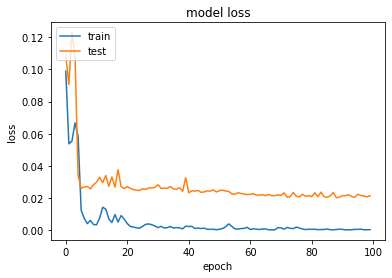

In [24]:
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Use test sample set to observe prediction

In [53]:
test_sample_predict=estimator.predict(test_sample)
test_sample_predict_round=np.round(test_sample_predict,0)

In [54]:
unique_elements, counts_elements = np.unique(test_sample_predict_round, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[ -0.   1.]
 [977.   2.]]


In [55]:
test_sample_predict_round[test_sample_index_1_crash[0]]

array([-0., -0., -0., -0., -0.,  0.,  0.,  1., -0.,  0.], dtype=float32)

In [56]:
test_sample_predict_round[test_sample_index_2_crash[0]]

array([0.], dtype=float32)

In [57]:
mean_sq_error=estimator.score(test_sample, test_sample_label)
print("Baseline: %.2f MSE" % (mean_sq_error))

Baseline: -0.02 MSE


In [58]:
# cv
kfold = KFold(n_splits=3)
results = cross_val_score(estimator,  sample, sample_label, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -0.01 (0.01) MSE


In [ ]:
# save model and architecture to single file
# model.save("model.h5")

In [ ]:
# load model
# model = load_model('model.h5')
# summarize model.
# model.summary()

In [ ]:
# evaluate small network: redundency in the input variables 

In [ ]:
# evaluate larger network: more layers

In [ ]:
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5,
verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# grid search model parameters
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
inits = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# reduced learning rate
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.0, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=50, batch_size=28, callbacks=callbacks_list,
verbose=2)

# 2. Classification

Categories ratio:  
* no crash: 1 crash: 2 crash: >=3 crashes = 4841 : 50 : 3 : 1  
* no crash: crash = 89 : 1  

In [38]:
# Convert numerical crash counts to categories 
sample_label_cat=sample_label
#sample_label_cat=sample_label_cat_cat.replace([4, 5, 6,7,8,9,10], 3)

In [39]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(sample_label_cat)
encoded_label = encoder.transform(sample_label_cat)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_label = np_utils.to_categorical(encoded_label)

In [40]:
dummy_label

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [41]:
dummy_label=pd.DataFrame(dummy_label,columns=['no_crash', '1_crash', '2_crash'])

In [42]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(261, input_dim=261, activation='relu'))
    model.add(Dense(3, activation='softmax')) # 0, 1, 2, >=3 crashes
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # research other more appropriate matrics available
    return model
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0, validation_split=0.33)

In [43]:
t0 = time()
history_clas=estimator.fit(sample, dummy_label)
t1 = time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 18.03s


## Plot model history

In [44]:
print(history_clas.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Observations:
* Model performance stopped improving after 80 epoch (why fluctuation after 40 epoch?)  
* Model might have over-learned the training dataset

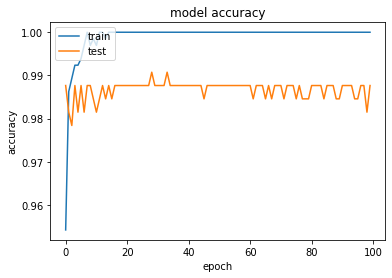

In [46]:
# summarize history for accuracy
plt.plot(history_clas.history['accuracy'])
plt.plot(history_clas.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
sample_predict= estimator.predict(sample, verbose=1)
print(classification_report(sample_label, sample_predict))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
196/196 [==============================] - 0s 877us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       968
         1.0       1.00      0.70      0.82        10
         2.0       0.00      0.00      0.00         1

    accuracy                           1.00       979
   macro avg       0.67      0.57      0.61       979
weighted avg       0.99      1.00      1.00       979



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Use test sample set to observe prediction

In [48]:
test_sample_predict= estimator.predict(test_sample, verbose=1)
print(classification_report(test_sample_label, test_sample_predict))

196/196 [==============================] - 0s 794us/step
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       968
         1.0       0.25      0.10      0.14        10
         2.0       0.00      0.00      0.00         1

    accuracy                           0.99       979
   macro avg       0.41      0.37      0.38       979
weighted avg       0.98      0.99      0.98       979



In [ ]:
# Test the model using a differnet optimizer with a relatively low learning rate and momentum
sgd = SGD(lr=0.01, momentum=0.8) # model.compile(optimizer=sgd)

In [ ]:
kfold = KFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# checkpoint

In [152]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# How to load and use weights from a checkpoint
create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# load weights
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))